# Get slope data given lat and lon 

## We will use slope data from https://www.landfire.gov/version_download.php# 

In [1]:
import geopandas as gpd
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [9]:
#File paths
data_path      = '/Users/hrh/Desktop/AI/erdos/rapower_data/'
data_path2     = '/Users/hrh/Desktop/AI/erdos/SolarFarmPrediction/data/'
ca_gridpath    = data_path2 + 'CA_data_version_0.csv'
slope_datapath = data_path + 'LF2020_SlpD_220_CONUS/'

### Read lats and lons for CA into a GeoDataframe

In [6]:
df_main             = pd.read_csv(ca_gridpath)
ca_grid             = df_main.loc[df_main['State']=='CA']
# ca_grid_usable      = ca_grid.loc[ca_grid['land_cover']==1.0]
ca_coords           = list(zip(ca_grid['Latitude'], ca_grid['Longitude']))
#Check if ca_coords are within california grid box
ca_lats = [item[0] for item in ca_coords] 
ca_lons = [item[1] for item in ca_coords]
(min(ca_lats),max(ca_lats)),(min(ca_lons),max(ca_lons))

((32.53767702167681, 42.00186839932766),
 (-124.47184652921426, -114.13859171386824))

In [14]:
ca_grid

,Latitude,Longitude,Solar_farm_present,State,panel.area,power,panels,landscape.area,water,urban,Address
0,40.417985,-124.471847,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,40.437539,-124.471847,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,40.457093,-124.471847,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,40.398431,-124.450274,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,40.417985,-124.450274,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
102145,34.277993,-114.160164,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102146,34.297547,-114.160164,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102147,34.317101,-114.160164,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102148,34.258439,-114.138592,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Create a GeoDataFrame for California coordinates
geometry = [Point(xy) for xy in ca_coords]
# ca_gdf   = gpd.GeoDataFrame(geometry=geometry)
ca_gdf   = gpd.GeoDataFrame({
    'geometry': [Point(lon, lat) for lat, lon in ca_coords]
}, crs="EPSG:4326")  # Make sure to set the correct coordinate reference system
ca_gdf

,geometry
0,POINT (-124.47185 40.41799)
1,POINT (-124.47185 40.43754)
2,POINT (-124.47185 40.45709)
3,POINT (-124.45027 40.39843)
4,POINT (-124.45027 40.41799)
...,...
102145,POINT (-114.16016 34.27799)
102146,POINT (-114.16016 34.29755)
102147,POINT (-114.16016 34.31710)
102148,POINT (-114.13859 34.25844)


### Read slope data 

In [16]:
#Slope data path 
slope_tif_path = slope_datapath + 'Tif/LC20_SlpD_220.tif'
# Open the slope raster
# Check the CRS of the GeoDataFrame and the Raster
with rasterio.open(slope_tif_path) as src:
    print(f"Raster CRS: {src.crs}")
    print(f"Raster Bounds: {src.bounds}")

print(f"GeoDataFrame CRS: {ca_gdf.crs}")

Raster CRS: EPSG:5070
Raster Bounds: BoundingBox(left=-2362395.0, bottom=221265.0, right=2327655.0, top=3267405.0)
GeoDataFrame CRS: EPSG:4326


In [17]:
with rasterio.open(slope_tif_path) as src:
    #Convert the ca_gdf dataframe to the crs of the source
    ca_gdf = ca_gdf.to_crs(src.crs)
    # Mask the raster with the GeoDataFrame to get the slope values for California coordinates
    # out_image, out_transform = mask(src, [g for g in ca_gdf['geometry'].values], crop=True)
    # ca_slope_data            = out_image[0]  # Assuming slope data is in the first band
    # Sample the raster at the given points
    ca_slope_values = [val[0] for val in src.sample([(geom.x, geom.y) for geom in ca_gdf.geometry])]


In [18]:
len(ca_slope_values)

102150

In [19]:
# Create a DataFrame from the sampled slope values
ca_slope = pd.DataFrame({
    'lat': [geom.y for geom in ca_gdf.geometry],
    'lon': [geom.x for geom in ca_gdf.geometry],
    'slope': ca_slope_values
})

In [20]:
ca_slope

,lat,lon,slope
0,2.289950e+06,-2.359659e+06,0
1,2.292043e+06,-2.359013e+06,0
2,2.294136e+06,-2.358366e+06,0
3,2.287321e+06,-2.358571e+06,0
4,2.289414e+06,-2.357925e+06,0
...,...,...,...
102145,1.404102e+06,-1.649158e+06,3
102146,1.406249e+06,-1.648743e+06,31
102147,1.408395e+06,-1.648327e+06,20
102148,1.401582e+06,-1.647637e+06,0


###  Convert the DataFrame back to a GeoDataFrame with the original CRS (EPSG:4326)

In [30]:
#CRS transformation after creating a geodata frame
ca_slope_gdf = gpd.GeoDataFrame(ca_slope, geometry=gpd.points_from_xy(ca_slope.lon, ca_slope.lat),crs='EPSG:5070') # Set to raster's CRS to match the sampling
print('The coordinate reference system of ca_slope_gdf is:',ca_slope_gdf.crs)

# Now, reproject to EPSG:4326
ca_slope_gdf = ca_slope_gdf.to_crs("EPSG:4326")
print('The coordinate reference system of ca_slope_gdf is:',ca_slope_gdf.crs)

# Assuming 'ca_slope_gdf' has been correctly reprojected to EPSG:4326
ca_slope_gdf['lat'] = ca_slope_gdf.geometry.y
ca_slope_gdf['lon'] = ca_slope_gdf.geometry.x

The coordinate reference system of ca_slope_gdf is: EPSG:5070
The coordinate reference system of ca_slope_gdf is: EPSG:4326


In [31]:
# Verify the transformation
ca_slope_gdf

,lat,lon,slope,geometry
0,40.417999,-124.471844,0,POINT (-124.47184 40.41800)
1,40.437553,-124.471844,0,POINT (-124.47184 40.43755)
2,40.457107,-124.471843,0,POINT (-124.47184 40.45711)
3,40.398444,-124.450272,0,POINT (-124.45027 40.39844)
4,40.417998,-124.450272,0,POINT (-124.45027 40.41800)
...,...,...,...,...
102145,34.277993,-114.160164,3,POINT (-114.16016 34.27799)
102146,34.297547,-114.160164,31,POINT (-114.16016 34.29755)
102147,34.317101,-114.160164,20,POINT (-114.16016 34.31710)
102148,34.258439,-114.138592,0,POINT (-114.13859 34.25844)


#### Because of re-gridding, some points have no slope data and I have decided to set those slopes to None

In [35]:
no_data_locations = ca_slope_gdf[ca_slope_gdf['slope'] == -9999]
no_data_locations

,lat,lon,slope,geometry
1889,39.401171,-123.889387,-9999,POINT (-123.88939 39.40117)
2137,39.205630,-123.846242,-9999,POINT (-123.84624 39.20563)
2734,39.029643,-123.759952,-9999,POINT (-123.75995 39.02964)
5044,38.619007,-123.457936,-9999,POINT (-123.45794 38.61901)
12970,37.797734,-122.595034,-9999,POINT (-122.59503 37.79773)
...,...,...,...,...
80735,32.537677,-117.201895,-9999,POINT (-117.20189 32.53768)
80736,32.557231,-117.201895,-9999,POINT (-117.20189 32.55723)
80737,32.576785,-117.201895,-9999,POINT (-117.20189 32.57679)
80738,32.596339,-117.201895,-9999,POINT (-117.20189 32.59634)


In [36]:
ca_slope_gdf.loc[ca_slope_gdf['slope'] == -9999, 'slope'] = None

### Finally, load the CA shape file and check if the slope information makes sense by plotting 

EPSG:4326


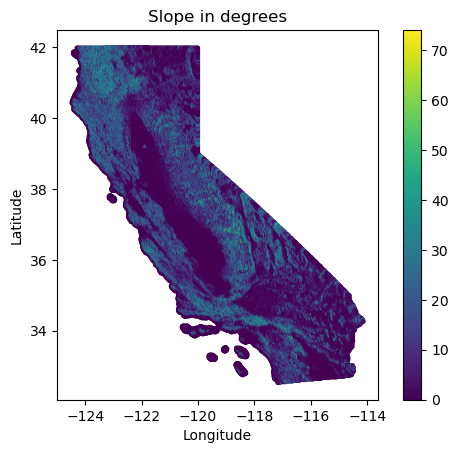

In [37]:
# Load the California shapefile
ca_shapfile_path = data_path+ 'ca_state_boundary/CA_State_TIGER2016.shp'
ca_shape         = gpd.read_file(ca_shapfile_path)
ca_shape         = ca_shape.to_crs("EPSG:4326")
print(ca_shape.crs)
# Plot the California shapefile as the base
ca_shape.plot(color='white', edgecolor='black')

# Plot the slope data
ca_slope_gdf.plot(ax=plt.gca(), column='slope', legend=True, markersize=5, cmap='viridis')

plt.title('Slope in degrees')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


## Finally, save the dataframe to a csv file after dropping the 'geometry' column

In [38]:
# Save to CSV
ca_slope_gdf.drop(columns='geometry').to_csv('ca_data_version_1.csv', index=False)

In [40]:
#Check
ca_slope_check = pd.read_csv('ca_data_version_1.csv')
ca_slope_check

,lat,lon,slope
0,40.417999,-124.471844,0.0
1,40.437553,-124.471844,0.0
2,40.457107,-124.471843,0.0
3,40.398444,-124.450272,0.0
4,40.417998,-124.450272,0.0
...,...,...,...
102145,34.277993,-114.160164,3.0
102146,34.297547,-114.160164,31.0
102147,34.317101,-114.160164,20.0
102148,34.258439,-114.138592,0.0


### Add slope data to the big dataframe ------ Ignore this piece of code. No longer relevant----------------

In [15]:
conus_features0 = pd.read_csv('data_LandCover_Cities.csv')
ca_features0    = conus_features0.loc[df_main['State']=='CA']
ca_features     = ca_features0.rename(columns={'Latitude': 'lat', 'Longitude': 'lon'})
ca_features

,lat,lon,State,panel.area,power,panels,landscape.area,water,urban,Address,demand_10km_MWh,demand_20km_MWh,demand_50km_MWh,land_cover,min distance to city (in miles)
2,37.405176,-122.084769,CA,0.000141,NaN,1.0,0.0,0.0,1.0,"1625 San Luis Ave, Mountain View, CA 94043, USA",5.801625e+06,1.021578e+07,1.054983e+07,0.0,1.4160
3,37.847173,-122.271529,CA,0.000141,NaN,1.0,0.0,0.0,1.0,"3372 Martin Luther King Jr Way, Berkeley, CA 9...",5.308202e+06,6.235440e+06,7.062910e+06,1.0,3.3332
4,37.154450,-121.560230,CA,0.000141,NaN,1.0,0.0,0.0,0.0,"16600 Finley Ridge Rd, Morgan Hill, CA 95037, USA",4.974155e+06,4.974155e+06,9.388313e+06,1.0,33.7577
5,38.006981,-122.086832,CA,0.000141,NaN,1.0,0.0,0.0,1.0,"150 Nardi Ln, Martinez, CA 94553, USA",4.974155e+06,4.974155e+06,6.235440e+06,0.0,11.8221
6,38.089888,-122.142635,CA,0.000141,NaN,1.0,0.0,0.0,1.0,"3VQ4+XW Benicia, CA, USA",4.974155e+06,4.974155e+06,6.235440e+06,1.0,16.3706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7986,34.293795,-114.357804,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.974155e+06,4.974155e+06,4.974155e+06,1.0,240.5314
7987,34.392355,-114.357804,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.974155e+06,4.974155e+06,4.974155e+06,1.0,269.8006
7988,34.195234,-114.249069,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.974155e+06,4.974155e+06,4.974155e+06,1.0,222.2860
7989,34.293795,-114.249069,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.974155e+06,4.974155e+06,4.974155e+06,1.0,243.1461


In [19]:
# Ensure both GeoDataFrames have the same CRS
# Convert ca_features to a GeoDataFrame
gdf_ca_features = gpd.GeoDataFrame(
    ca_features, 
    geometry=gpd.points_from_xy(ca_features.lon, ca_features.lat),
    crs="EPSG:4326"
)

# Ensure ca_slope is a GeoDataFrame with the same CRS
gdf_ca_slope = gpd.GeoDataFrame(
    ca_slope_check,
    geometry=gpd.points_from_xy(ca_slope_check.lon, ca_slope_check.lat),
    crs="EPSG:4326"
)

# Reproject to a suitable projected CRS for accurate distance calculations
gdf_ca_features = gdf_ca_features.to_crs("EPSG:3310")
gdf_ca_slope    = gdf_ca_slope.to_crs("EPSG:3310")


In [22]:
# Perform the spatial join to find the nearest neighbors and get their 'slope'
ca_features_with_slope = gpd.sjoin_nearest(gdf_ca_features, gdf_ca_slope[['geometry', 'slope']], how='left', distance_col='distance')

# If you don't need the distance information, drop the 'distance' column
ca_features_with_slope.drop(columns=['index_right', 'distance',], inplace=True)

# Optionally, project back to geographic CRS if needed for other purposes
ca_features_with_slope = ca_features_with_slope.to_crs("EPSG:4326")

ca_features_with_slope

,lat,lon,State,panel.area,power,panels,landscape.area,water,urban,Address,demand_10km_MWh,demand_20km_MWh,demand_50km_MWh,land_cover,min distance to city (in miles),geometry,slope
2,37.405176,-122.084769,CA,0.000141,NaN,1.0,0.0,0.0,1.0,"1625 San Luis Ave, Mountain View, CA 94043, USA",5.801625e+06,1.021578e+07,1.054983e+07,0.0,1.4160,POINT (-122.08477 37.40518),0
3,37.847173,-122.271529,CA,0.000141,NaN,1.0,0.0,0.0,1.0,"3372 Martin Luther King Jr Way, Berkeley, CA 9...",5.308202e+06,6.235440e+06,7.062910e+06,1.0,3.3332,POINT (-122.27153 37.84717),1
4,37.154450,-121.560230,CA,0.000141,NaN,1.0,0.0,0.0,0.0,"16600 Finley Ridge Rd, Morgan Hill, CA 95037, USA",4.974155e+06,4.974155e+06,9.388313e+06,1.0,33.7577,POINT (-121.56023 37.15445),9
5,38.006981,-122.086832,CA,0.000141,NaN,1.0,0.0,0.0,1.0,"150 Nardi Ln, Martinez, CA 94553, USA",4.974155e+06,4.974155e+06,6.235440e+06,0.0,11.8221,POINT (-122.08683 38.00698),3
6,38.089888,-122.142635,CA,0.000141,NaN,1.0,0.0,0.0,1.0,"3VQ4+XW Benicia, CA, USA",4.974155e+06,4.974155e+06,6.235440e+06,1.0,16.3706,POINT (-122.14264 38.08989),2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7986,34.293795,-114.357804,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.974155e+06,4.974155e+06,4.974155e+06,1.0,240.5314,POINT (-114.35780 34.29379),27
7987,34.392355,-114.357804,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.974155e+06,4.974155e+06,4.974155e+06,1.0,269.8006,POINT (-114.35780 34.39236),8
7988,34.195234,-114.249069,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.974155e+06,4.974155e+06,4.974155e+06,1.0,222.2860,POINT (-114.24907 34.19523),1
7989,34.293795,-114.249069,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.974155e+06,4.974155e+06,4.974155e+06,1.0,243.1461,POINT (-114.24907 34.29379),9


In [23]:
ca_features_with_slope.loc[ca_features_with_slope['land_cover']==1.0]['slope']

3        1
4        9
6        2
11       0
12       0
        ..
7986    27
7987     8
7988     1
7989     9
7990    20
Name: slope, Length: 3677, dtype: int64

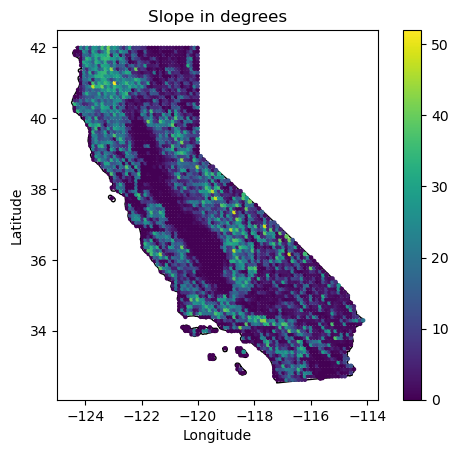

In [24]:
# Plot the California shapefile as the base
ca_shape.plot(color='white', edgecolor='black')

# Plot the slope data
ca_features_with_slope.plot(ax=plt.gca(), column='slope', legend=True, markersize=5, cmap='viridis',  missing_kwds={
        "color": "white",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    })

plt.title('Slope in degrees')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### Finally, save this data as a CSV file

In [25]:
ca_features_with_slope.drop(columns='geometry').to_csv('ca_lc_city_slope.csv', index=False)

In [28]:
ca_features_with_slope_check = pd.read_csv('ca_lc_city_slope.csv')
ca_features_with_slope_check 

,lat,lon,State,panel.area,power,panels,landscape.area,water,urban,Address,demand_10km_MWh,demand_20km_MWh,demand_50km_MWh,land_cover,min distance to city (in miles),slope
0,37.405176,-122.084769,CA,0.000141,NaN,1.0,0.0,0.0,1.0,"1625 San Luis Ave, Mountain View, CA 94043, USA",5.801625e+06,1.021578e+07,1.054983e+07,0.0,1.4160,0
1,37.847173,-122.271529,CA,0.000141,NaN,1.0,0.0,0.0,1.0,"3372 Martin Luther King Jr Way, Berkeley, CA 9...",5.308202e+06,6.235440e+06,7.062910e+06,1.0,3.3332,1
2,37.154450,-121.560230,CA,0.000141,NaN,1.0,0.0,0.0,0.0,"16600 Finley Ridge Rd, Morgan Hill, CA 95037, USA",4.974155e+06,4.974155e+06,9.388313e+06,1.0,33.7577,9
3,38.006981,-122.086832,CA,0.000141,NaN,1.0,0.0,0.0,1.0,"150 Nardi Ln, Martinez, CA 94553, USA",4.974155e+06,4.974155e+06,6.235440e+06,0.0,11.8221,3
4,38.089888,-122.142635,CA,0.000141,NaN,1.0,0.0,0.0,1.0,"3VQ4+XW Benicia, CA, USA",4.974155e+06,4.974155e+06,6.235440e+06,1.0,16.3706,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4939,34.293795,-114.357804,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.974155e+06,4.974155e+06,4.974155e+06,1.0,240.5314,27
4940,34.392355,-114.357804,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.974155e+06,4.974155e+06,4.974155e+06,1.0,269.8006,8
4941,34.195234,-114.249069,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.974155e+06,4.974155e+06,4.974155e+06,1.0,222.2860,1
4942,34.293795,-114.249069,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.974155e+06,4.974155e+06,4.974155e+06,1.0,243.1461,9
